In [52]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
from shapely.geometry import Point
import requests, zipfile, io
from zipfile import ZipFile
import gzip
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

## Load in data

### Load in Natural Earth data

Loading in the higher resolution (10m) Natural Earth data and plotting it

In [53]:
ne_10m = 'https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip'

r = requests.get(ne_10m)
#Check that the request was successful
assert r.ok
# Unzip the data
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data/countries/")

# Read in country shapefile
world_high_res = gpd.read_file('data/countries/ne_10m_admin_0_countries.shp')

In [54]:
#Save list of entities
world_high_res['Country'] = world_high_res['NAME']
world_high_res.to_csv('data/countries/nat_earth_country_names_high_res.csv', index=False, columns = ['Country'])

Loading in the lower resolution Natural Earth data (more similar to OWID country entities) and plotting it

In [55]:
# Get country data for low resolution map - OWID Style
ne_110m = 'https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip'

r = requests.get(ne_110m)
#Check that the request was successful
assert r.ok
# Unzip the data
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data/countries/")

# Read in country shapefile
world_low_res = gpd.read_file('data/countries/ne_110m_admin_0_countries.shp')

In [56]:
#Save list of entities
world_low_res['Country'] = world_low_res['NAME']
world_low_res.to_csv('data/countries/nat_earth_country_names_low_res.csv', index=False, columns = ['Country'])

### Load in the clean UCDP georeferenced data

In [57]:
df = pd.read_csv(gzip.open('data/manipulation/combined_and_tidied_geolocated_data.csv.gz', 'rb'))
df.tail()

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7,10,13,16,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,data_source,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,dyad_new_id,dyad_name,side_a_dset_id,side_a_new_id,side_a,side_b_dset_id,side_b_new_id,side_b,number_of_sources,source_article,source_office,source_date,source_headline,source_original,where_prec,where_coordinates,where_description,adm_1,adm_2,latitude,longitude,geom_wkt,priogrid_gid,country,country_id,region,event_clarity,date_prec,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnoa,gwnob,high_amend,low_amend
280250,candidate_monthly,428546,YEM-2022-2-14596-0,2022,0,Clear,2,14596,13587,AQAP - Forces of Hadi,14596,14596,AQAP - Forces of Hadi,881,881,AQAP,6254,6254,Forces of Hadi,1,"""Airwars,2022-02-06,USYEMBi006""",Airwars,2022-02-06,USYEMBi006,Airwars,2,Kawlah village,"الكولة, Al Kawlah/Al Kola area in Wadi Ubayda",Marib governorate,Marib district,15.546860,45.413790,POINT (45.41379 15.54686),152371,Yemen (North Yemen),678,Middle East,1,1,2022-02-06 00:00:00.000,2022-02-06 00:00:00.000,0,3,1,0,4,5,4,NaN,NaN,5,4
280251,candidate_monthly,430944,YEM-2022-3-15781-1,2022,0,Check,3,6254,14511,Forces of Hadi - Civilians,6254,15781,Forces of Hadi - Civilians,6254,6254,Forces of Hadi,9999,1,Civilians,1,"""BBC Monitoring Middle East,2022-03-04,News si...",BBC Monitoring Middle East,2022-03-04,News site links southern Yemen separatist forc...,Al-Masdar,2,Dar Saad suburb,Dar Saad district,‘Adan governorate,Dār Sa‘d district,12.889167,44.987222,POINT (44.987222 12.889167),148050,Yemen (North Yemen),678,Middle East,1,4,2022-02-22 00:00:00.000,2022-03-03 00:00:00.000,0,0,1,0,1,1,1,NaN,NaN,1,1
280252,candidate_monthly,430843,YEM-2022-2-15915-1,2022,0,Check,2,15915,14623,Forces of Hadi - STC,15915,15915,Forces of Hadi - STC,6254,6254,Forces of Hadi,7344,7344,STC,1,"""BBC Monitoring Middle East,2022-02-19,Yemen g...",BBC Monitoring Middle East,2022-02-19,Yemen gunmen shoot dead brother of former Shab...,security source,4,Shabwah governorate,province of Shabwa,Shabwah governorate,NaN,15.000000,47.000000,POINT (47 15),151655,Yemen (North Yemen),678,Middle East,1,1,2022-02-19 00:00:00.000,2022-02-19 00:00:00.000,0,0,0,2,2,2,2,NaN,NaN,2,2
280253,candidate_monthly,428117,YEM-2022-2-17014-0,2022,0,Clear,2,17014,15505,Giants Brigade - STC,17014,17014,Giants Brigade - STC,8276,8276,Giants Brigade,7344,7344,STC,1,"""BBC Monitoring Middle East,2022-02-04,'Mediat...",BBC Monitoring Middle East,2022-02-04,'Mediators resolve infighting' between Yemen s...,Al-Masdar Online,4,Laḩij governorate,province of Lahj,Laḩij governorate,NaN,13.166667,44.583332,POINT (44.583332 13.166667),148770,Yemen (North Yemen),678,Middle East,1,1,2022-02-01 00:00:00.000,2022-02-01 00:00:00.000,1,0,0,0,1,1,1,NaN,NaN,1,1
280254,candidate_monthly,431229,ZIM-2022-2-2-XXX552-0,2022,0,Check dyad,2,2-XXX552,173,XXX552 - XXX552,2-XXX552,346,XXX552 - XXX552,XXX552,3768,XXX552,XXX552,3768,XXX552,5,"""Amnesty International,2022-02-28,Zimbabwe: In...",Amnesty International;Agence France Presse;All...,2022-02-28;2022-02-28;2022-03-03;2022-03-03;20...,Zimbabwe: Investigate violence on political op...,Amnesty International,1,Kwekwe town,Mbizo 4 shopping centre in Kwekwe,Midlands province,Kwekwe district,-18.928095,29.814863,POINT (29.814863 -18.928095),102660,Zimbabwe (Rhodesia),552,Africa,1,1,2022-02-27 00:00:00.000,2022-02-27 00:00:00.000,0,1,0,0,1,1,1,NaN,NaN,1,1


## Map locations to countries

Convert the UCDP data to a GeoDataFrame (so it can be mapped and used in spatial analysis). The 'wkt.loads' function takes the coordinates in the 'geometry' column and ensures geopandas will use it to map the data.

In [58]:
df_geo = df[['relid','geom_wkt']]
df_geo.rename(columns={"geom_wkt":"geometry"}, inplace=True)
df_geo['geometry'] = df_geo['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df_geo, crs='epsg:4326')

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/var/folders/rz/2g82f4z111vbcp20h8dy8snh0000gn/T/ipykernel_50675/854620756.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo['geometry'] = df_geo['geometry'].apply(wkt.loads)


Plot the UCDP data points on the world map to check it looks sensible

<AxesSubplot:>

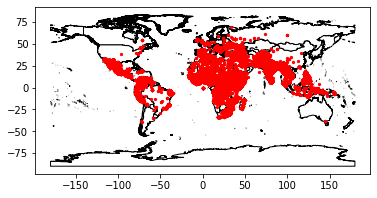

In [59]:
base = world_high_res.plot(color='white', edgecolor='black')
gdf.plot(ax=base, marker='o', color='red', markersize=5)


Use the overlay function to extract data from the world map that each point sits on top of.

In [60]:
ucdp_ne = gpd.overlay(gdf, world_high_res, how='intersection')

Checking we have extracted a country value for each point - if we have the number of rows in the dataframes will be the same.

In [61]:
ucdp_ne.shape[0] == df.shape[0]

False

There are 1688 points that are missed - likely because they are in the sea perhaps due to the conflict either happening at sea or at the coast and the coordinates are slightly inaccurate. 

In [62]:
df.shape[0] - ucdp_ne.shape[0]

1688

Identifying which points have not yet been assigned a country

In [63]:
ucdp_orig = gdf.relid.to_list() 
ucdp_ex = ucdp_ne.relid.to_list()

main_list = list(set(ucdp_orig) - set(ucdp_ex))

In [64]:
missing_pts = gdf[gdf.relid.isin(main_list)]

Reprojecting the points and the world into the World Equidistant Cylindrical Sphere projection.

In [65]:
wec_crs = '+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6371007 +b=6371007 +units=m +no_defs'
missing_pts_wec = missing_pts.to_crs(wec_crs)
world_high_res_wec = world_high_res.to_crs(wec_crs)

For these points we can find the nearest country using the distance function

In [66]:
polygon_near = []
for index, row in missing_pts_wec.iterrows():
    polygon_index = world_high_res_wec.distance(row['geometry']).sort_values().index[0]
    nat_earth_country_name = world_high_res_wec['NAME'][polygon_index]
    polygon_near.append(nat_earth_country_name)

Assigning the closest countries to the missing_pts data frame

In [67]:
missing_pts['NAME'] = polygon_near

/usr/local/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [68]:
missing_pts.head()

,relid,geometry,NAME
36971,ALG-1992-1-1-28,POINT (3.01148 36.81745),Algeria
36987,ALG-1992-1-1-44,POINT (2.92185 36.80277),Algeria
36988,ALG-1992-1-1-45,POINT (3.16667 36.75000),Algeria
37004,ALG-1992-1-1-61,POINT (3.91311 36.91716),Algeria
37149,ALG-1993-1-1-82,POINT (2.84389 36.76111),Algeria


Merging the extracted countries (ucdp_ne) back into the original dataframe and noting the method used - 'Intersect'

In [69]:
df_intersect = df.merge(ucdp_ne[["relid", "NAME"]], on = "relid")
df_intersect.rename(columns = {"NAME":"nat_earth_country_name"}, inplace = True)
df_intersect['method'] = 'Intersect'

Merging the extracted countries (missing_pts) back into the original dataframe and noting the method used - 'Nearest'

In [70]:
df_nearest = df.merge(missing_pts[["relid", "NAME"]], on = "relid")
df_nearest.rename(columns = {"NAME":"nat_earth_country_name"}, inplace = True)
df_nearest['method'] = 'Nearest'

We now have data for all the UCDP points - we can check this by seeing if our dataframe with extracted countries has the same number of rows as the original dataframe.

In [71]:
df_country= df_intersect.append(df_nearest).reset_index()


df_country.shape[0] == df.shape[0]

True

To align with OWID borders we will rename the conflicts in Somaliland to Somalia and the conflicts in Morocco that were below 27.66727 latitude to Western Sahara.

In [72]:
print(f"{len(df_country.loc[(df_country.nat_earth_country_name == 'Somaliland'),'nat_earth_country_name'])} datapoints in Somaliland")
df_country.loc[(df_country.nat_earth_country_name == 'Somaliland'),'nat_earth_country_name'] = 'Somalia'
print(f"{len(df_country.loc[(df_country.nat_earth_country_name == 'Morocco') & (df_country.latitude < 27.66727),'nat_earth_country_name'])} datapoints in land contested by Morocco/W.Sahara")
df_country.loc[(df_country.nat_earth_country_name == 'Morocco') & (df_country.latitude < 27.66727),'nat_earth_country_name'] = "Western Sahara"

155 datapoints in Somaliland
7 datapoints in land contested by Morocco/W.Sahara


I've added a flag column for points which I think are likely to have incorrect coordinates - points where latitude and longitude are exactly the same, or both 0.

In [73]:
df_country['flag'] = ""
df_country['flag'][df_country['geom_wkt'] == 'POINT (0 0)'] = 'Coordinates 0,0'
df_country['nat_earth_country_name'][df_country['geom_wkt'] == 'POINT (0 0)'] = ""

/var/folders/rz/2g82f4z111vbcp20h8dy8snh0000gn/T/ipykernel_50675/1110667567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['flag'][df_country['geom_wkt'] == 'POINT (0 0)'] = 'Coordinates 0,0'
/var/folders/rz/2g82f4z111vbcp20h8dy8snh0000gn/T/ipykernel_50675/1110667567.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['nat_earth_country_name'][df_country['geom_wkt'] == 'POINT (0 0)'] = ""


In [74]:
df_country['flag'][df_country.latitude == df_country.longitude] = "Latitude and Longitude same"
df_country['nat_earth_country_name'][df_country.latitude == df_country.longitude] = ""

/var/folders/rz/2g82f4z111vbcp20h8dy8snh0000gn/T/ipykernel_50675/1701016178.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['flag'][df_country.latitude == df_country.longitude] = "Latitude and Longitude same"
/var/folders/rz/2g82f4z111vbcp20h8dy8snh0000gn/T/ipykernel_50675/1701016178.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['nat_earth_country_name'][df_country.latitude == df_country.longitude] = ""


## Map to OWID country names

Load mapping file

In [75]:
mapping = pd.read_csv('data/countries/country_names_low_res_country_standardized.csv')
mapping.head()

,Country,Our World In Data Name
0,Fiji,Fiji
1,Tanzania,Tanzania
2,W. Sahara,Western Sahara
3,Canada,Canada
4,United States of America,United States


Rename original UCDP country name to make it explicit which is which

In [76]:
df_country.rename(columns = {"country":"UCDP_country"}, inplace = True)

Merge in OWID names

In [77]:
df_country = pd.merge(df_country, mapping, left_on='nat_earth_country_name', right_on='Country', how='left')

df_country.drop(columns=['Country'])

df_country.rename(columns = {"Our World In Data Name":'Country'}, inplace = True)



## Output as zipped csv

In [81]:
df_country.to_csv('data/manipulation/ucdp_with_country.csv.gz', index = False, compression = "gzip")